# 0. Заголовок и цель

Markdown

название проекта

что решаем: предсказание alpha (0..255), метрика MSE

данные: MAGICK (train), Kaggle test (orig_1024)

## 1. Импорты и глобальные настройки

Импорты, настройки PIL, базовые зависимости

In [19]:
import os
import io
import sys
import base64
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

Image.MAX_IMAGE_PIXELS = None

Все параметры меняются здесь

In [20]:
Image.MAX_IMAGE_PIXELS = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# пути
TRAIN_CSV = Path("data/splits/train.csv")
VAL_CSV   = Path("data/splits/val.csv")
TEST_ROOT = Path("data/test_dataset/orig_1024")  # твой тест Kaggle
MODEL_DIR = Path("outputs/experiments/exp_001")
MODEL_DIR.mkdir(parents=True, exist_ok=True)


TRAIN_SIZE = (512, 512)
VAL_SIZE   = (1024, 1024)
TRAIN_BATCH = 4
VAL_BATCH   = 1

LIMIT_DATA = 100
   
NUM_EPOCHS = 4
LR = 1e-4
RUN_TRAINING = True

## 2. Датасеты и аугментации


In [21]:
class CsvAlphaDataset(Dataset):
    """
    Ожидает CSV с колонками:
      - image_path
      - alpha_path
    Возвращает dict как в baseline:
      {"img": tensor, "mask": tensor}
    """
    def __init__(self, csv_path: Path, size=(1024, 1024), normalize=True, augment=None, limit=LIMIT_DATA,
                 shadow_aug_p=0.6, shadow_strength_range=(0.06, 0.18), shadow_width_iters_range=(4, 10)):
        self.csv_path = Path(csv_path)
        self.df = pd.read_csv(self.csv_path)

        if limit is not None:
            self.df = self.df.head(int(limit)).reset_index(drop=True)
            
        self.size = size
        self.augment = augment
        
        # Параметры shadow-as-alpha аугментации (применяется только для train, когда augment не None)
        # Обновлено: "часто, но слабо" - больше примеров с полутонами без "грязи"
        self.shadow_aug_p = shadow_aug_p
        self.shadow_strength_range = shadow_strength_range
        self.shadow_width_iters_range = shadow_width_iters_range

        # ВАЖНО: Если есть augment (train), то augment делает crop до crop_size,
        # и НЕ нужно делать Resize до size - это размывает края альфы!
        # Для val: НЕ делаем Resize - работаем с full-res для корректной валидации
        # Resize убран, чтобы валидация соответствовала инференсу на full-res
        use_resize = False  # Убрали Resize для валидации

        # Трансформы как в baseline
        if normalize:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.extend([
                transforms.ToTensor(),
                #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # RGB -> [-1, 1]
                transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225]),
            ])
            self.image_transforms = transforms.Compose(transform_list)
        else:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.append(transforms.ToTensor())  # [0,1]
            self.image_transforms = transforms.Compose(transform_list)

        # Маска/альфа: нам важно сохранить значения 0..1 (без Normalize)
        mask_transform_list = []
        if use_resize:
            mask_transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
        mask_transform_list.append(transforms.ToTensor())  # L -> [0,1], shape [1,H,W]
        self.mask_transforms = transforms.Compose(mask_transform_list)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = Path(row["image_path"])
        mask_path = Path(row["alpha_path"])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 0..255

        if self.augment is not None:
            img, mask = self.augment(img, mask)

        img_t = self.image_transforms(img)
        mask_t = self.mask_transforms(mask)  # [1, H, W] в [0, 1]

        # Shadow-as-alpha аугментация: применяем только для train (когда augment не None)
        # Это создаёт полутона внутри объекта, чтобы модель лучше училась предсказывать мягкие альфа-каналы
        if self.augment is not None:
            alpha = mask_t[0]  # (H, W) извлекаем альфа-канал
            alpha = shadow_as_alpha(
                alpha,
                p=self.shadow_aug_p,
                strength_range=self.shadow_strength_range,
                width_iters_range=self.shadow_width_iters_range
            )
            mask_t = alpha.unsqueeze(0)  # возвращаем обратно в (1, H, W)

        return {"img": img_t, "mask": mask_t}


class TestImageDataset(Dataset):
    def __init__(self, root: Path, size=(1024, 1024)):
        self.root = Path(root)
        self.images = sorted([p for p in self.root.iterdir() if p.is_file()])
        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
            transforms.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        img = Image.open(path).convert("RGB")
        return {"path": path.name, "img": self.transform(img)}

In [22]:
class JointAugment:
    def __init__(self, size=512, p_flip=0.5, p_rotate=0.0, max_rotate=10, p_color=0.7):
        self.crop_size = size
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.max_rotate = max_rotate
        self.p_color = p_color

    def __call__(self, img_pil, mask_pil):
        # random crop (одинаково для img и mask)
        i, j, h, w = transforms.RandomCrop.get_params(img_pil, output_size=(self.crop_size, self.crop_size))
        img_pil = TF.crop(img_pil, i, j, h, w)
        mask_pil = TF.crop(mask_pil, i, j, h, w)

        # flip
        if random.random() < self.p_flip:
            img_pil = TF.hflip(img_pil)
            mask_pil = TF.hflip(mask_pil)

        # rotate с явным fill для корректной обработки краёв
        if self.p_rotate and random.random() < self.p_rotate:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            # fill=255 для RGB (белый фон) - уменьшает "туман" на светлом фоне
            # fill=0 для mask (прозрачность)
            # expand=False: не расширяем изображение, обрезаем углы
            img_pil = TF.rotate(img_pil, angle, interpolation=InterpolationMode.BILINEAR, fill=255, expand=False)
            mask_pil = TF.rotate(mask_pil, angle, interpolation=InterpolationMode.BILINEAR, fill=0, expand=False)

        # color jitter only for img
        if random.random() < self.p_color:
            b = random.uniform(0.85, 1.15)
            c = random.uniform(0.85, 1.15)
            s = random.uniform(0.85, 1.15)
            img_pil = TF.adjust_brightness(img_pil, b)
            img_pil = TF.adjust_contrast(img_pil, c)
            img_pil = TF.adjust_saturation(img_pil, s)

        return img_pil, mask_pil


### Shadow-as-alpha аугментация

Создаёт полутона внутри объекта (не только на границе), чтобы модель лучше училась предсказывать мягкие альфа-каналы, как в реальных e-commerce изображениях.

**Применяется только для train данных** (когда `augment` не None).

**Параметры (обновлено: "часто, но слабо"):**
- `shadow_aug_p=0.6`: вероятность применения (60% примеров) - больше примеров с полутонами
- `shadow_strength_range=(0.06, 0.18)`: диапазон силы тени - уменьшена для меньшей "грязи"
- `shadow_width_iters_range=(4, 10)`: диапазон ширины полосы тени - уменьшена ширина

**Как работает:**
1. Находит границу объекта через морфологический градиент
2. Создаёт плавную "полосу тени" около границы внутри объекта
3. **Сглаживает shadow_map через двойной avg_pool2d** - убирает "пятна" и делает градиент плавным
4. Уменьшает альфа в этой области, но не ниже разумного пола (0.35-0.75)
5. Фон остаётся нетронутым (alpha ≈ 0)

**Преимущества:**
- Больше примеров с полутонами (60% вместо 30%)
- Меньше "грязи" благодаря уменьшенной силе
- Плавный градиент благодаря сглаживанию shadow_map

In [23]:
# Translucency/X-ray аугментация: создание полутонов внутри объекта на основе яркости RGB
# Это помогает модели учиться предсказывать мягкие альфа-каналы, как в реальных e-commerce изображениях
# Внутри объекта альфа становится меньше там, где светлее/ближе к бликам

def translucency_xray(alpha01: torch.Tensor, rgb01: torch.Tensor, p: float = 0.4, 
                      strength_range=(0.15, 0.55), blur_k: int = 31) -> torch.Tensor:
    """
    alpha01: (H,W) float [0,1]
    rgb01: (3,H,W) float [0,1] - RGB изображение в диапазоне [0,1] (до нормализации
    p: вероятность применения аугментации (0.4 = 40% примеров)
    strength_range: диапазон силы эффекта (0.15-0.55)
    blur_k: размер ядра для сглаживания яркости (31)
    
    Создаёт гладкие полутона внутри объекта на основе яркости RGB:
    - Внутри объекта альфа становится меньше там, где светлее/ближе к бликам
    - Всё гладко благодаря blur
    """
    if torch.rand(()) > p:
        return alpha01

    obj = (alpha01 > 0.1).float()

    # Вычисляем яркость RGB (стандартная формула)
    r, g, b = rgb01[0], rgb01[1], rgb01[2]
    gray = (0.299 * r + 0.587 * g + 0.114 * b).clamp(0, 1)

    # Сглаживаем яркость, чтобы не было пятен
    x = gray[None, None]  # 1x1xHxW
    pad = blur_k // 2
    smooth = F.avg_pool2d(x, kernel_size=blur_k, stride=1, padding=pad)[0, 0]

    # Нормируем в 0..1 внутри объекта
    t = smooth
    t_min = t.min()
    t_max = t.max()
    t = (t - t_min) / (t_max - t_min + 1e-6)

    strength = float(torch.empty(1).uniform_(*strength_range).item())

    # Уменьшаем альфу внутри объекта пропорционально яркости
    alpha_new = alpha01 * (1.0 - strength * t * obj)

    # Фон не трогаем
    alpha_new = alpha_new * obj + alpha01 * (1.0 - obj)

    # Пол внутри объекта (чтобы не сделать "призрак")
    floor = float(torch.empty(1).uniform_(0.45, 0.85).item())
    alpha_new = torch.where(
        obj > 0.5,
        torch.maximum(alpha_new, torch.tensor(floor, device=alpha01.device, dtype=alpha01.dtype)),
        alpha_new
    )

    return alpha_new.clamp(0, 1)

Геометрия синхронно img+mask, фотометрия только img

Создадим Dataloaders для аугментации train данных

In [24]:
train_aug = JointAugment(size=512, p_flip=0.5, p_rotate=0.3, max_rotate=10, p_color=0.7)

train_ds = CsvAlphaDataset(TRAIN_CSV, size=TRAIN_SIZE, augment=train_aug, limit=LIMIT_DATA)
val_ds   = CsvAlphaDataset(VAL_CSV, size=VAL_SIZE, augment=None, limit=LIMIT_DATA)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=0, pin_memory=True)

Проверяем, что пайплайн данных верный

### Визуализация изображений и маттинга из train_processed


In [25]:
train_batch = next(iter(train_loader))
print(train_batch["img"].shape, train_batch["img"].min().item(), train_batch["img"].max().item())
print(train_batch["mask"].shape, train_batch["mask"].min().item(), train_batch["mask"].max().item())
val_batch = next(iter(val_loader))
print(val_batch["img"].shape, val_batch["img"].min().item(), val_batch["img"].max().item())


torch.Size([4, 3, 512, 512]) -2.1179039478302 2.640000104904175
torch.Size([4, 1, 512, 512]) 0.0 1.0
torch.Size([1, 3, 1024, 1024]) -2.1179039478302 2.5354249477386475


### Визуализация shadow-as-alpha аугментации

Показываем примеры изображений с применённой shadow-as-alpha аугментацией для проверки эффекта


[1] Image:
  Original: range=[0.000, 1.000], mean=0.517, mid-tones=2.25%
  Augmented: range=[0.000, 1.000], mean=0.687, mid-tones=2.48%
  Difference: max=1.000, mean=0.673

[2] Image:
  Original: range=[0.000, 1.000], mean=0.882, mid-tones=0.70%
  Augmented: range=[1.000, 1.000], mean=1.000, mid-tones=0.00%
  Difference: max=1.000, mean=0.118

[3] Image:
  Original: range=[0.000, 1.000], mean=0.357, mid-tones=1.95%
  Augmented: range=[0.000, 1.000], mean=0.417, mid-tones=2.68%
  Difference: max=1.000, mean=0.070

[4] Image:
  Original: range=[0.000, 1.000], mean=0.471, mid-tones=1.98%
  Augmented: range=[0.000, 1.000], mean=0.831, mid-tones=7.79%
  Difference: max=1.000, mean=0.686

[5] Image:
  Original: range=[0.000, 1.000], mean=0.780, mid-tones=2.51%
  Augmented: range=[0.000, 1.000], mean=0.939, mid-tones=0.79%
  Difference: max=1.000, mean=0.165

[6] Image:
  Original: range=[0.000, 1.000], mean=0.542, mid-tones=5.71%
  Augmented: range=[0.000, 1.000], mean=0.660, mid-tones=3.06

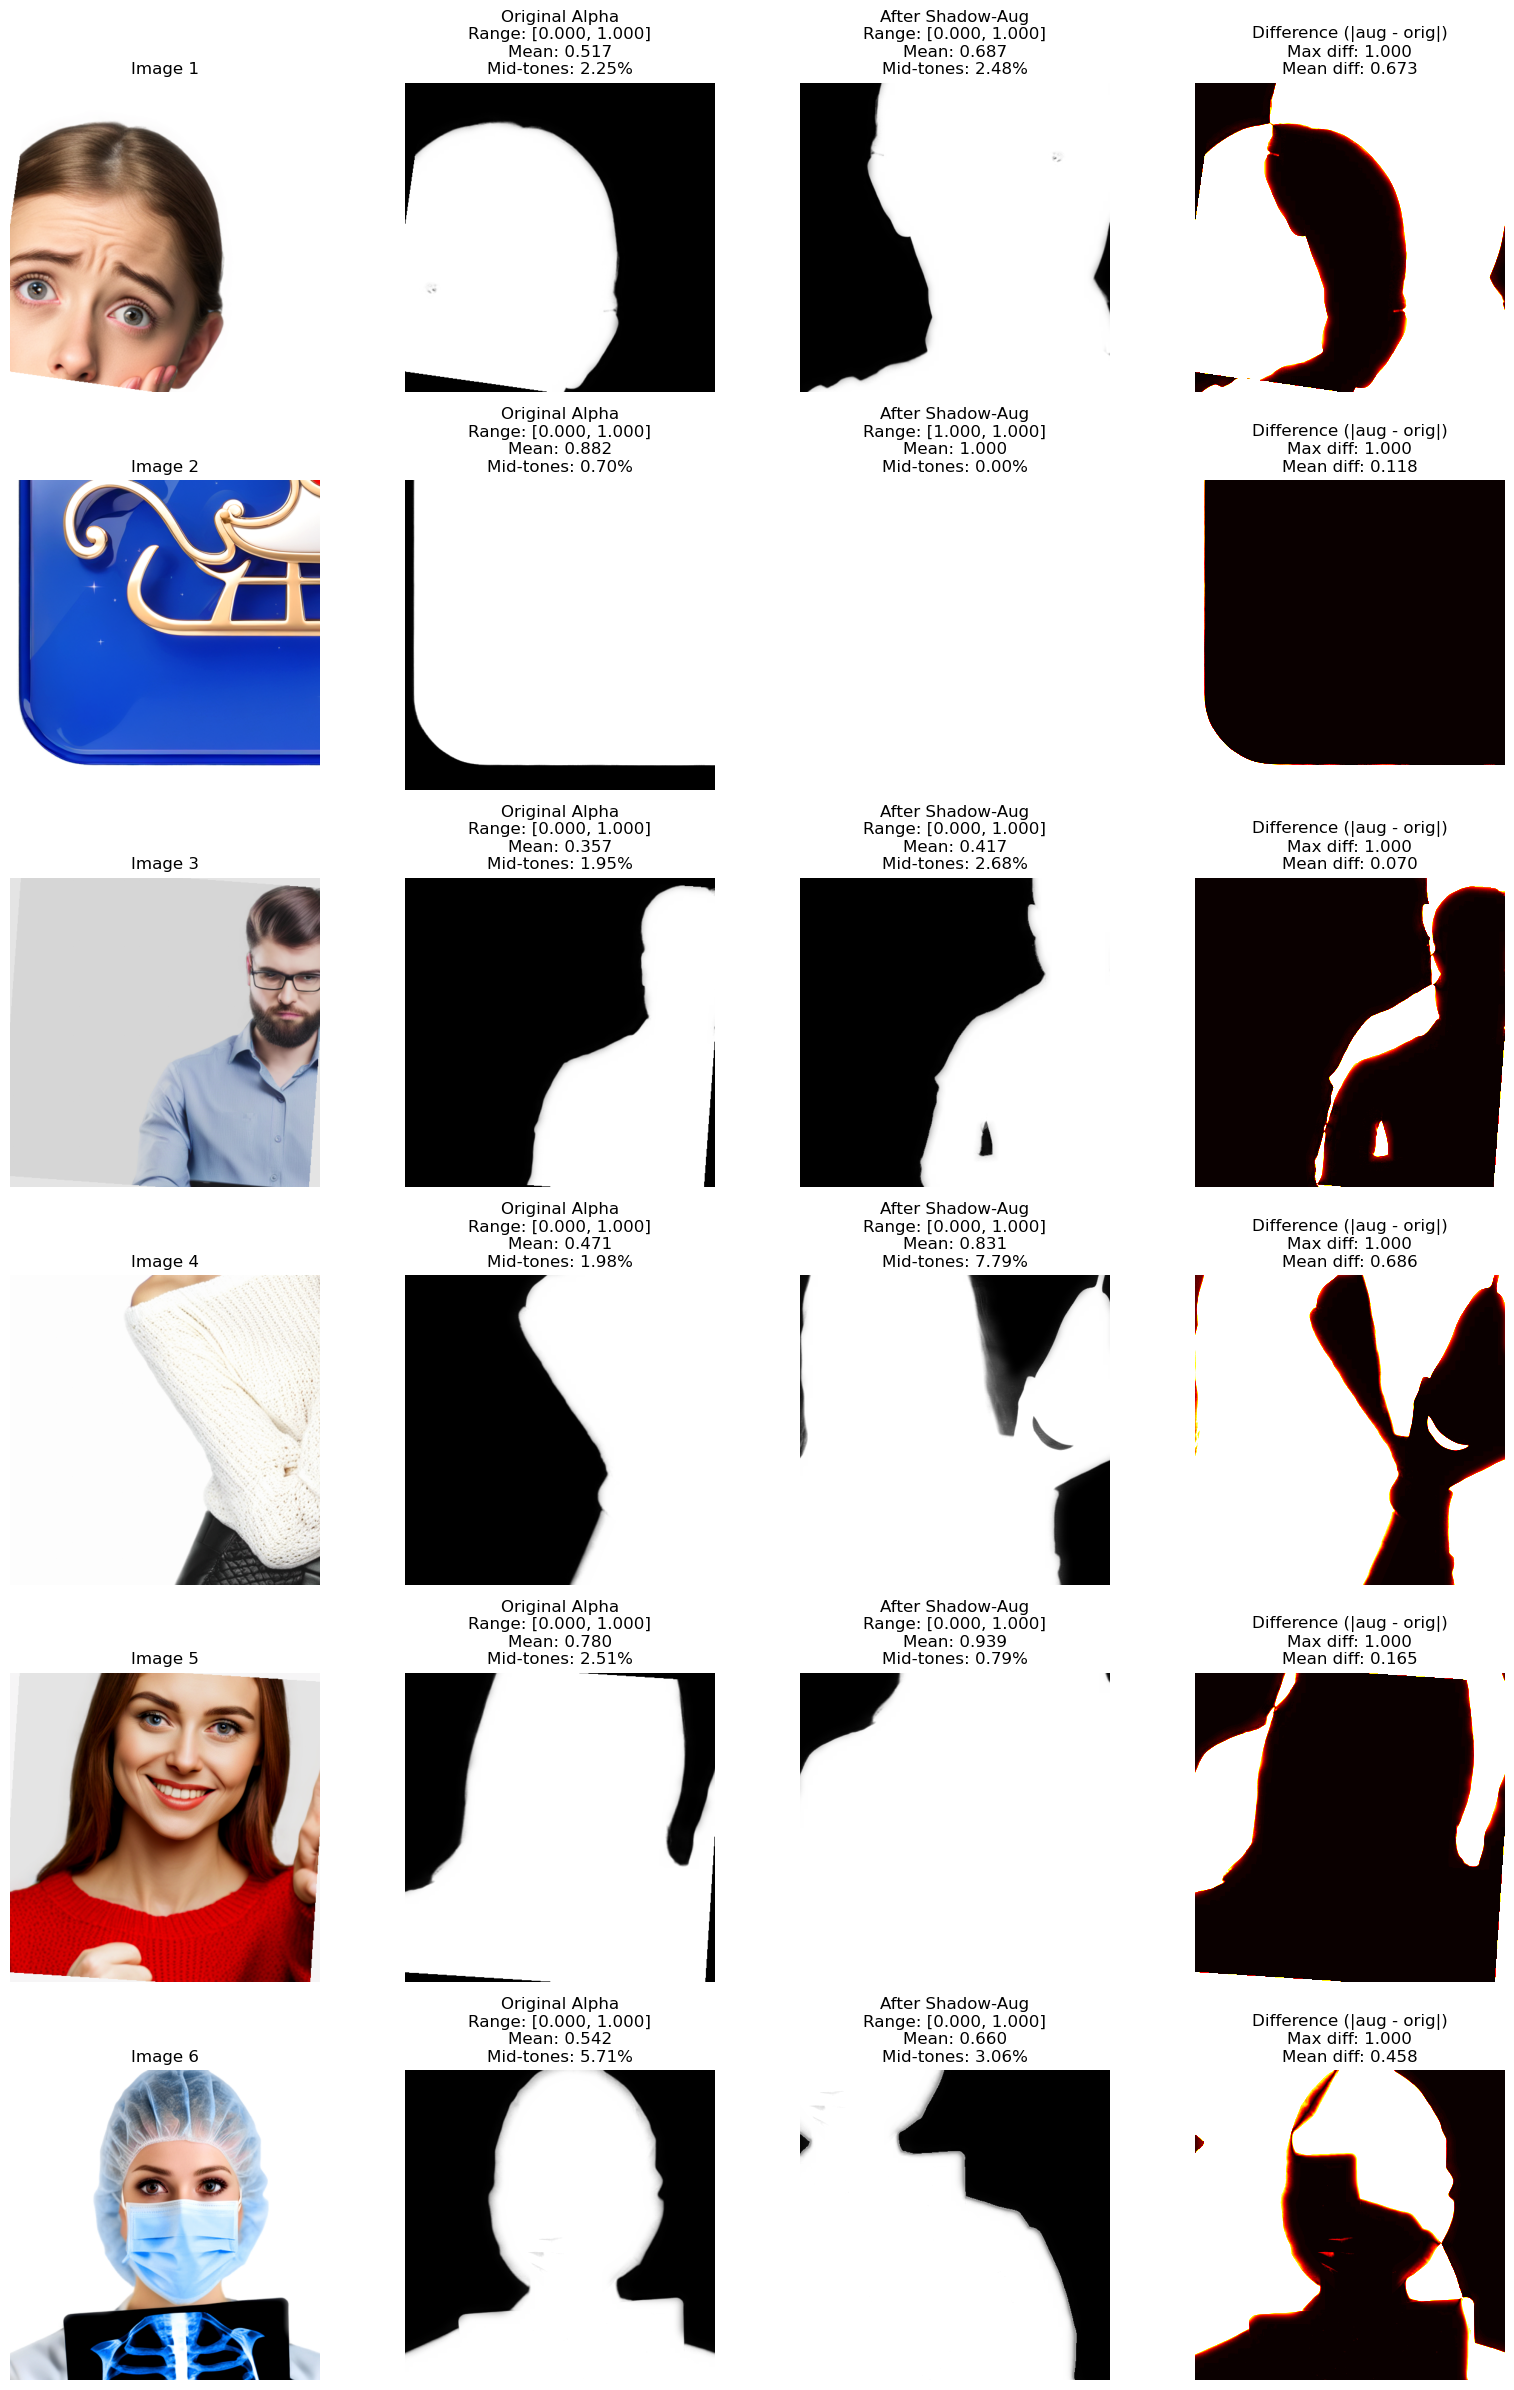


Визуализация shadow-as-alpha аугментации завершена


In [26]:
# Визуализация shadow-as-alpha аугментации: сравнение оригинальных и затемнённых масок
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import pandas as pd
from pathlib import Path

def denorm_img(x):
    # x: [3,H,W] нормализованное -> [H,W,3] в [0,1]
    x = x.detach().cpu()
    # Обратная нормализация ImageNet
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    x = x * std + mean
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

# Загружаем CSV для прямого доступа к изображениям
train_csv = pd.read_csv(TRAIN_CSV)
n_show = min(6, len(train_csv))

# Создаём временный датасет БЕЗ shadow-as-alpha для сравнения
from torchvision import transforms
temp_ds_no_shadow = CsvAlphaDataset(TRAIN_CSV, size=TRAIN_SIZE, augment=train_aug, limit=LIMIT_DATA,
                                     shadow_aug_p=0.0)  # Отключаем shadow-as-alpha
temp_loader_no_shadow = DataLoader(temp_ds_no_shadow, batch_size=1, shuffle=False, num_workers=0)

# Создаём датасет С shadow-as-alpha
temp_ds_with_shadow = CsvAlphaDataset(TRAIN_CSV, size=TRAIN_SIZE, augment=train_aug, limit=LIMIT_DATA,
                                      shadow_aug_p=0.6, shadow_strength_range=(0.06, 0.18), 
                                      shadow_width_iters_range=(4, 10))
temp_loader_with_shadow = DataLoader(temp_ds_with_shadow, batch_size=1, shuffle=True, num_workers=0)

fig, axes = plt.subplots(n_show, 4, figsize=(16, 4 * n_show))

for idx in range(n_show):
    # Берём один и тот же индекс из обоих загрузчиков
    # Для этого используем фиксированный seed или берём по индексу
    batch_no_shadow = temp_ds_no_shadow[idx]
    batch_with_shadow = temp_ds_with_shadow[idx]
    
    img_t = batch_no_shadow["img"]  # [3, H, W]
    mask_orig_t = batch_no_shadow["mask"]  # [1, H, W] без shadow-as-alpha
    mask_aug_t = batch_with_shadow["mask"]  # [1, H, W] с shadow-as-alpha
    
    # Конвертируем в numpy для визуализации
    img_np = denorm_img(img_t)
    mask_orig_np = mask_orig_t[0].detach().cpu().numpy()  # [H, W] в [0, 1]
    mask_aug_np = mask_aug_t[0].detach().cpu().numpy()  # [H, W] в [0, 1]
    
    # Статистика
    orig_min, orig_max = mask_orig_np.min(), mask_orig_np.max()
    aug_min, aug_max = mask_aug_np.min(), mask_aug_np.max()
    orig_mean = mask_orig_np.mean()
    aug_mean = mask_aug_np.mean()
    
    # Доля полутонов (значения между 0.05 и 0.95)
    orig_mid_frac = np.mean((mask_orig_np > 0.05) & (mask_orig_np < 0.95))
    aug_mid_frac = np.mean((mask_aug_np > 0.05) & (mask_aug_np < 0.95))
    
    # Разница между оригиналом и аугментированной маской
    diff = np.abs(mask_aug_np - mask_orig_np)
    
    # Визуализация
    axes[idx, 0].imshow(img_np)
    axes[idx, 0].set_title(f"Image {idx+1}")
    axes[idx, 0].axis("off")
    
    axes[idx, 1].imshow(mask_orig_np, cmap="gray", vmin=0, vmax=1)
    axes[idx, 1].set_title(f"Original Alpha\nRange: [{orig_min:.3f}, {orig_max:.3f}]\nMean: {orig_mean:.3f}\nMid-tones: {orig_mid_frac:.2%}")
    axes[idx, 1].axis("off")
    
    axes[idx, 2].imshow(mask_aug_np, cmap="gray", vmin=0, vmax=1)
    axes[idx, 2].set_title(f"After Shadow-Aug\nRange: [{aug_min:.3f}, {aug_max:.3f}]\nMean: {aug_mean:.3f}\nMid-tones: {aug_mid_frac:.2%}")
    axes[idx, 2].axis("off")
    
    # Разница между оригиналом и аугментированной маской
    axes[idx, 3].imshow(diff, cmap="hot", vmin=0, vmax=0.3)
    axes[idx, 3].set_title(f"Difference (|aug - orig|)\nMax diff: {diff.max():.3f}\nMean diff: {diff.mean():.3f}")
    axes[idx, 3].axis("off")
    
    # Выводим статистику в консоль
    print(f"\n[{idx+1}] Image:")
    print(f"  Original: range=[{orig_min:.3f}, {orig_max:.3f}], mean={orig_mean:.3f}, mid-tones={orig_mid_frac:.2%}")
    print(f"  Augmented: range=[{aug_min:.3f}, {aug_max:.3f}], mean={aug_mean:.3f}, mid-tones={aug_mid_frac:.2%}")
    print(f"  Difference: max={diff.max():.3f}, mean={diff.mean():.3f}")

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Визуализация shadow-as-alpha аугментации завершена")
print("="*60)

## 3.Модель U2NETP + загрузка pretrained

Инициализация модели и pretrained весов

In [27]:
u2net_path = Path("U-2-Net")
if str(u2net_path.absolute()) not in sys.path:
    sys.path.insert(0, str(u2net_path.absolute()))

from model.u2net import U2NETP  
import torch

model = U2NETP(in_ch=3, out_ch=1).to(device)

# Путь к чекпойнту тоже нужно исправить
ckpt_path = Path("U-2-Net/saved_models/u2netp/u2netp.pth")
ckpt = torch.load(ckpt_path, map_location="cpu")
# иногда в чекпойнте просто state_dict, иногда dict со state_dict
state = ckpt if isinstance(ckpt, dict) and "state_dict" not in ckpt else ckpt.get("state_dict", ckpt)
model.load_state_dict(state, strict=True)

<All keys matched successfully>

## 4. Loss / Metric для U2NETP

In [28]:
def u2net_outputs_to_list(outputs):
    """
    Преобразует выходы модели в список.
    U2NETP возвращает tuple из 7 тензоров: (d0, d1, d2, d3, d4, d5, d6)
    """
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def sobel(x):
    """
    Sobel оператор для вычисления градиентов (краёв).
    x: (B,1,H,W) float [0..1]
    """
    kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], device=x.device, dtype=x.dtype).view(1,1,3,3)
    gx = F.conv2d(x, kx, padding=1)
    gy = F.conv2d(x, ky, padding=1)
    return torch.sqrt(gx*gx + gy*gy + 1e-6)

def u2net_mse_loss(outputs, target):
    """
    Edge-aware и bg-aware loss для U2NETP (минимальный и рабочий вариант).
    
    1) bg-aware: штраф за ненулевой фон (увеличен вес для борьбы с пятнами на фоне)
    2) edge-aware: заставить совпадать градиенты (границы)
    3) Итоговый loss: base MSE + 0.2 * edge_loss + 0.2 * bg_loss
    
    ВАЖНО: Модель U2NETP уже применяет sigmoid в forward,
    поэтому здесь НЕ нужно применять sigmoid повторно!
    """
    outs = u2net_outputs_to_list(outputs)
    total_loss = 0.0
    
    for out in outs:
        # pred, gt: (B,1,H,W) float [0..1]
        pred = out
        gt = target
        
        # Базовый MSE loss
        base = F.mse_loss(pred, gt)
        
        # 1) bg-aware: штраф за ненулевой фон (увеличен вес с 0.1 до 0.2)
        bg_mask = (gt < 0.01).float()  # Маска фона (где GT близок к 0)
        bg_loss = (pred * bg_mask).pow(2).sum() / (bg_mask.sum() + 1e-6)  # MSE на фоне
        
        # 2) edge-aware: заставить совпадать градиенты (границы)
        edge_loss = (sobel(pred) - sobel(gt)).abs().mean()
        
        # 3) Итоговый loss (увеличен вес bg_loss с 0.1 до 0.2 для борьбы с пятнами на фоне)
        loss = base + 0.2 * edge_loss + 0.2 * bg_loss
        
        total_loss += loss
    
    return total_loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """
    Метрика MSE по главному выходу (d0).
    ВАЖНО: Модель U2NETP уже применяет sigmoid в forward,
    поэтому здесь НЕ нужно применять sigmoid повторно!
    """
    # метрику считаем по главному выходу (обычно первый, d0)
    out0 = u2net_outputs_to_list(outputs)[0]
    # Модель уже вернула вероятности [0,1], применяем MSE напрямую
    return F.mse_loss(out0, target)

Лосс — MSE+L1 по alpha, метрика — MSE по главному выходу

## 5. Train / Eval loops (с AMP)

AMP экономит VRAM и ускоряет обучение

In [29]:
USE_AMP = False
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="train", leave=False, total=len(loader)):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в train_epoch. Прерываем обучение.")
            print("loss:", loss)
            print("imgs min/max:", imgs.min().item(), imgs.max().item())
            print("masks min/max:", masks.min().item(), masks.max().item())
            raise RuntimeError("Non-finite loss")

        if USE_AMP:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total_loss += float(loss.detach().item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n


@torch.no_grad()
def eval_epoch(model, loader):
    """
    Стандартная валидация: считает loss/metric на выходах модели.
    """
    model.eval()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в eval_epoch. Прерываем валидацию.")
            print("loss:", loss)
            print("imgs min/max:", imgs.min().item(), imgs.max().item())
            print("masks min/max:", masks.min().item(), masks.max().item())
            raise RuntimeError("Non-finite loss")

        bs = imgs.size(0)
        total_loss += float(loss.item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n


@torch.no_grad()
def eval_epoch_inference_pipeline(model, loader):
    """
    Валидация через inference pipeline: повторяет тестовый инференс.
    model(img) → mask_uint8 → сравнить с gt в float [0,1]
    Это позволяет понять, где рождается туман/фон - в модели или в конвертации.
    """
    model.eval()
    total_mse = 0.0
    n_samples = 0

    for batch in tqdm(loader, desc="val-infer", leave=False):
        imgs = batch["img"].to(device, non_blocking=True)
        masks_gt = batch["mask"].to(device, non_blocking=True)  # [B, 1, H, W] в [0, 1]

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
            probs = out0  # [B, 1, H, W] в [0, 1]

        # Повторяем тестовый инференс pipeline
        for b in range(probs.size(0)):
            pred = probs[b, 0].cpu().numpy()  # [H, W] в [0, 1]
            
            # Конвертация в uint8 [0, 255] как в submission
            mask_uint8 = (pred * 255).astype(np.uint8)
            
            # Обратно в float [0, 1] для сравнения с GT
            mask_pred_float = mask_uint8.astype(np.float32) / 255.0
            
            # GT тоже в numpy для сравнения
            mask_gt_np = masks_gt[b, 0].cpu().numpy()  # [H, W] в [0, 1]
            
            # MSE между предсказанием (после uint8 конвертации) и GT
            mse = np.mean((mask_pred_float - mask_gt_np) ** 2)
            total_mse += mse
            n_samples += 1

    return total_mse / n_samples if n_samples > 0 else 0.0

## 6. Training run + сохранение лучшей модели

In [30]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [31]:
# Оптимизатор AdamW с weight decay для регуляризации
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Scheduler: уменьшает learning rate при отсутствии улучшения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

# Функция для получения уникального имени файла с номером
def get_unique_path(base_path):
    """Если файл существует, добавляет номер (2, 3, ...) к имени"""
    if not base_path.exists():
        return base_path
    
    base_dir = base_path.parent
    base_name = base_path.stem
    base_ext = base_path.suffix
    
    counter = 2
    while True:
        new_path = base_dir / f"{base_name}_{counter}{base_ext}"
        if not new_path.exists():
            return new_path
        counter += 1

best_val_mse = float("inf")
best_path_base = MODEL_DIR / "u2netp_best.pth"
best_path = get_unique_path(best_path_base)  # Получаем уникальное имя при первом сохранении

if RUN_TRAINING:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_mse = train_epoch(model, train_loader, optimizer)
        
        # Стандартная валидация (на выходах модели)
        val_loss, val_mse = eval_epoch(model, val_loader)
        
        # Обновляем learning rate на основе val_mse
        scheduler.step(val_mse)
        current_lr = optimizer.param_groups[0]["lr"]
        
        print(f"Epoch {epoch}: train_mse={train_mse:.6f} val_mse={val_mse:.6f} lr={current_lr:.2e}")

        # Сохраняем лучшую модель по стандартной val_mse
        if val_mse < best_val_mse:
            best_val_mse = val_mse
            # Если это первое сохранение, используем уже полученное уникальное имя
            # Если файл был удалён/перемещён, получаем новое уникальное имя
            if not best_path.exists() and best_path != best_path_base:
                best_path = get_unique_path(best_path_base)
            torch.save({"model_state": model.state_dict()}, best_path)
            print(f"  -> Сохранена лучшая модель: {best_path.name} (val_mse={best_val_mse:.6f})")
else:
    # При загрузке ищем последнюю сохранённую модель (с наибольшим номером)
    best_path_to_load = best_path_base
    if best_path_to_load.exists():
        # Базовая модель существует
        pass
    else:
        # Ищем модель с наибольшим номером
        max_counter = 0
        counter = 2
        while True:
            candidate = MODEL_DIR / f"u2netp_best_{counter}.pth"
            if candidate.exists():
                max_counter = counter
                counter += 1
            else:
                break
        
        if max_counter > 0:
            best_path_to_load = MODEL_DIR / f"u2netp_best_{max_counter}.pth"
    
    if best_path_to_load.exists():
        print(f"Загружаем модель: {best_path_to_load.name}")
        model.load_state_dict(torch.load(best_path_to_load, map_location=device)["model_state"])
    else:
        print(f"Модель не найдена в {MODEL_DIR}")


c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train:   0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


KeyboardInterrupt: 

In [ ]:
# Проверка после исправления: модель должна выдавать finite значения
print("=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===")
model.eval()
batch = next(iter(train_loader))
imgs = batch["img"].to(device)
masks = batch["mask"].to(device)

with torch.no_grad():
    outputs = model(imgs)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    
    print("out0 shape:", out0.shape)
    print("out0 min/max:", out0.min().item(), out0.max().item())
    print("out0 finite:", torch.isfinite(out0).all().item())
    
    # Проверяем loss и metric
    loss = u2net_mse_loss(outputs, masks)
    metric = u2net_mse_metric(outputs, masks)
    
    print("loss:", loss.item())
    print("metric:", metric.item())
    print("loss finite:", torch.isfinite(loss).item())
    print("metric finite:", torch.isfinite(metric).item())

print("\nЕсли все finite=True и значения разумные, то исправление работает!")


=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===
out0 shape: torch.Size([4, 1, 512, 512])
out0 min/max: 1.6075979089591463e-11 1.0
out0 finite: True
loss: 0.12144339829683304
metric: 0.09866885095834732
loss finite: True
metric finite: True

Если все finite=True и значения разумные, то исправление работает!


## 7. Быстрая визуализация

c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


GT  min/max/mean: 0.0 1.0 0.36881882
Pred min/max/mean: 2.3290723e-12 0.99999964 0.32060692


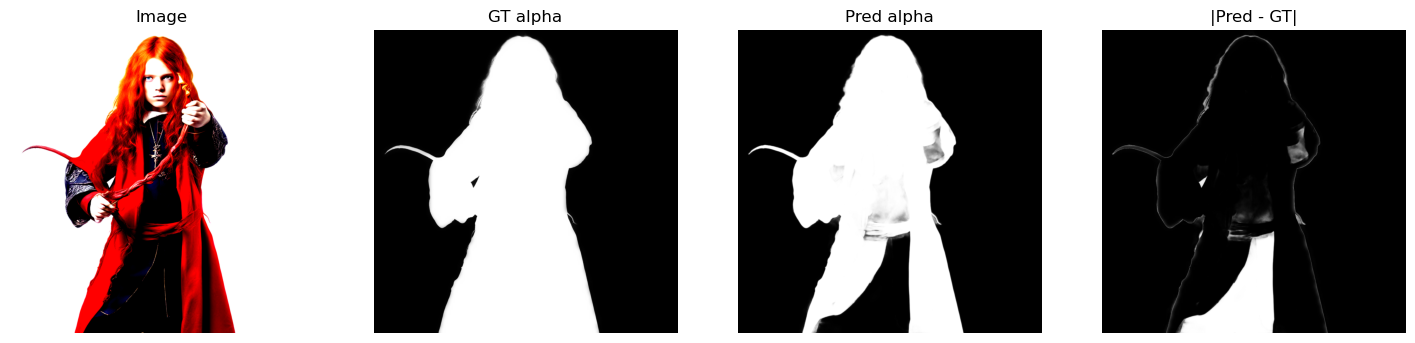

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denorm_img(x):
    # x: [3,H,W] в [-1,1] -> [H,W,3] в [0,1]
    x = x.detach().cpu()
    x = (x * 0.5 + 0.5).clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

@torch.no_grad()
def predict_alpha(model, img_tensor):
    # img_tensor: [1,3,H,W]
    outputs = model(img_tensor)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    # ИСПРАВЛЕНО: Модель U2NETP уже применяет sigmoid в forward
    # probs = torch.sigmoid(out0)  # СТАРЫЙ КОД с двойным sigmoid
    probs = out0  # [1,1,H,W] in [0,1] - модель уже вернула вероятности
    return probs

def show_val_examples(model, val_loader, n=3):
    model.eval()
    batch = next(iter(val_loader))
    imgs = batch["img"].to(device)
    gts  = batch["mask"].to(device)

    preds = predict_alpha(model, imgs)

    B = imgs.size(0)
    n = min(n, B)

    for i in range(n):
        img_np = denorm_img(imgs[i])
        gt_np  = gts[i,0].detach().cpu().numpy()
        pr_np  = preds[i,0].detach().cpu().numpy()
        print("GT  min/max/mean:", gt_np.min(), gt_np.max(), gt_np.mean())
        print("Pred min/max/mean:", pr_np.min(), pr_np.max(), pr_np.mean())

        diff   = np.abs(pr_np - gt_np)

        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        axes[0].imshow(img_np)
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(gt_np, cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("GT alpha")
        axes[1].axis("off")

        axes[2].imshow(pr_np, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Pred alpha")
        axes[2].axis("off")

        axes[3].imshow(diff, cmap="gray")
        axes[3].set_title("|Pred - GT|")
        axes[3].axis("off")

        plt.show()

# запуск после обучения:
show_val_examples(model, val_loader, n=10)


### Диагностика: анализ сырого инференса

Проверяем, где появляется туман/фон - в модели или в постпроцессе.


=== ДИАГНОСТИКА СЫРОГО ИНФЕРЕНСА (первые 3 изображения) ===

[1] 0001:
  pred01: min=0.0000, max=1.0000
  quantiles [0.01, 0.5, 0.99]: [4.17905410e-09 5.67644711e-05 9.99982953e-01]
  bg_estimate (1% quantile): 0.0000
  mid_frac_pred (доля 0.05-0.95): 0.0391
  mid_frac_uint8 (после uint8): 0.0393
  -> Изменение mid_frac: 0.0002
  ✅ Фон близок к 0 в модели: bg_estimate=0.0000
  ✅ Мягкие края сохраняются после uint8

[2] 0002:
  pred01: min=0.0000, max=1.0000
  quantiles [0.01, 0.5, 0.99]: [8.11667317e-10 2.90941316e-04 9.99993563e-01]
  bg_estimate (1% quantile): 0.0000
  mid_frac_pred (доля 0.05-0.95): 0.1165
  mid_frac_uint8 (после uint8): 0.1173
  -> Изменение mid_frac: 0.0008
  ✅ Фон близок к 0 в модели: bg_estimate=0.0000
  ✅ Мягкие края сохраняются после uint8

[3] 0003:
  pred01: min=0.0000, max=1.0000
  quantiles [0.01, 0.5, 0.99]: [3.79803533e-09 5.26848962e-05 9.99965340e-01]
  bg_estimate (1% quantile): 0.0000
  mid_frac_pred (доля 0.05-0.95): 0.0449
  mid_frac_uint8 (после u

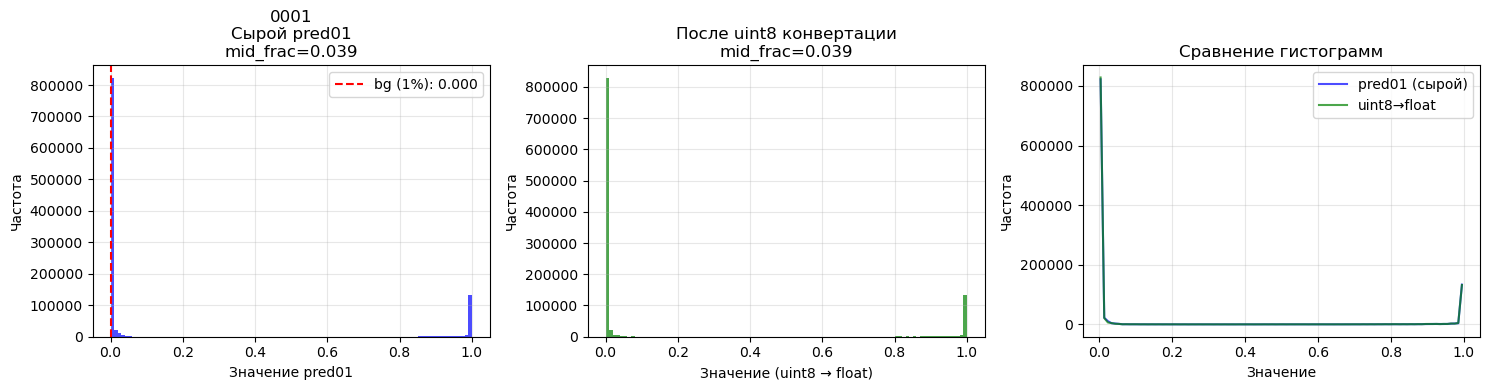

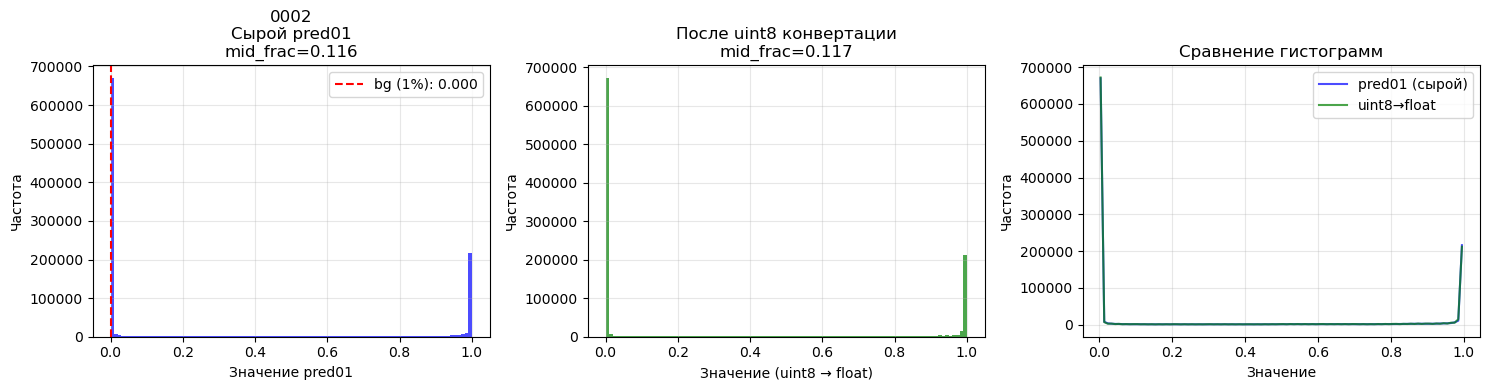

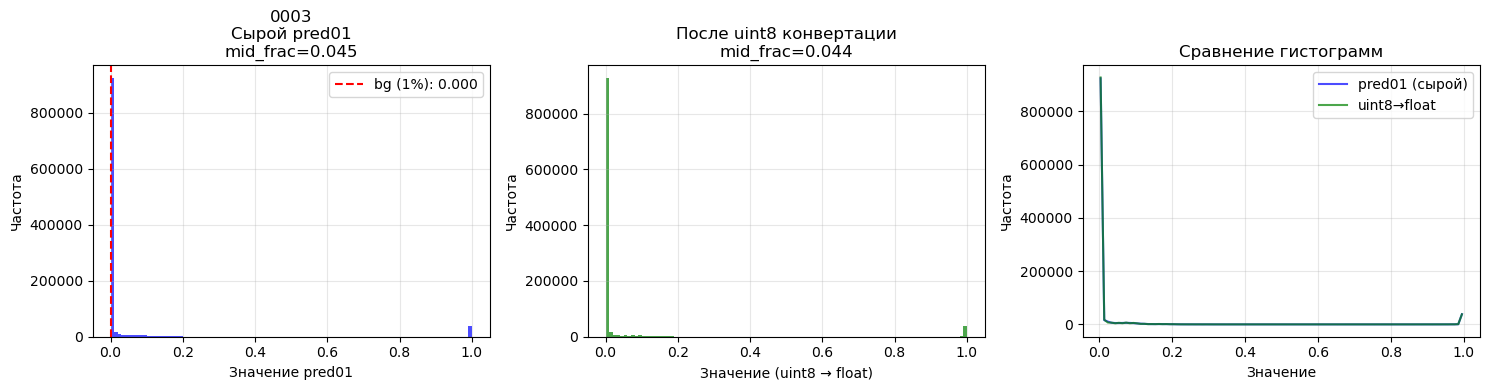

In [ ]:
# Шаг 1: "Сырой инференс" без постпроцесса на 2-3 тестовых изображениях
import matplotlib.pyplot as plt

model.eval()
test_dataset = TestImageDataset(TEST_ROOT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

n_diagnostic = min(3, len(test_dataset))
print(f"=== ДИАГНОСТИКА СЫРОГО ИНФЕРЕНСА (первые {n_diagnostic} изображения) ===\n")

results = []

with torch.no_grad():
    for idx, batch in enumerate(test_loader):
        if idx >= n_diagnostic:
            break
            
        imgs = batch["img"].to(device)
        names = batch["path"]
        filename = names[0].split(".")[0]
        
        outputs = model(imgs)
        out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        
        # Сырой выход модели без постпроцесса
        pred01 = out0.squeeze().cpu().numpy()  # [H, W] в диапазоне [0, 1]
        
        # Конвертация в uint8 (как в submission)
        uint8 = (pred01 * 255).clip(0, 255).astype(np.uint8)
        
        # Статистика сырого pred01
        pred_min = pred01.min()
        pred_max = pred01.max()
        quantiles = np.quantile(pred01, [0.01, 0.5, 0.99])
        bg_estimate = np.quantile(pred01, 0.01)  # Оценка фона
        
        # Доля "средних" значений (не бинарных)
        mid_frac_pred = np.mean((pred01 > 0.05) & (pred01 < 0.95))
        
        # После uint8 конвертации
        uint8_back_to_float = uint8.astype(np.float32) / 255.0
        mid_frac_uint8 = np.mean((uint8_back_to_float > 0.05) & (uint8_back_to_float < 0.95))
        
        print(f"[{idx+1}] {filename}:")
        print(f"  pred01: min={pred_min:.4f}, max={pred_max:.4f}")
        print(f"  quantiles [0.01, 0.5, 0.99]: {quantiles}")
        print(f"  bg_estimate (1% quantile): {bg_estimate:.4f}")
        print(f"  mid_frac_pred (доля 0.05-0.95): {mid_frac_pred:.4f}")
        print(f"  mid_frac_uint8 (после uint8): {mid_frac_uint8:.4f}")
        print(f"  -> Изменение mid_frac: {mid_frac_uint8 - mid_frac_pred:.4f}")
        
        # Диагностика фона
        if bg_estimate > 0.10:
            print(f"  ⚠️  ФОН ПОДНЯТ В МОДЕЛИ: bg_estimate={bg_estimate:.4f} > 0.10")
        elif bg_estimate < 0.05:
            print(f"  ✅ Фон близок к 0 в модели: bg_estimate={bg_estimate:.4f}")
        else:
            print(f"  ⚠️  Фон умеренно поднят: bg_estimate={bg_estimate:.4f}")
        
        if mid_frac_uint8 < mid_frac_pred * 0.8:
            print(f"  ⚠️  БИНАРИЗАЦИЯ ПРИ uint8: mid_frac упал с {mid_frac_pred:.4f} до {mid_frac_uint8:.4f}")
        else:
            print(f"  ✅ Мягкие края сохраняются после uint8")
        
        results.append({
            "filename": filename,
            "pred01": pred01,
            "uint8": uint8,
            "bg_estimate": bg_estimate,
            "mid_frac_pred": mid_frac_pred,
            "mid_frac_uint8": mid_frac_uint8
        })
        print()

# Шаг 2: Визуализация гистограмм до/после
print("\n=== ГИСТОГРАММЫ ДО/ПОСЛЕ uint8 КОНВЕРТАЦИИ ===\n")

for idx, res in enumerate(results):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Гистограмма pred01 (сырой выход)
    axes[0].hist(res["pred01"].flatten(), bins=100, range=(0, 1), alpha=0.7, color="blue")
    axes[0].axvline(res["bg_estimate"], color="red", linestyle="--", label=f"bg (1%): {res['bg_estimate']:.3f}")
    axes[0].set_xlabel("Значение pred01")
    axes[0].set_ylabel("Частота")
    axes[0].set_title(f"{res['filename']}\nСырой pred01\nmid_frac={res['mid_frac_pred']:.3f}")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Гистограмма после uint8 конвертации
    uint8_float = res["uint8"].astype(np.float32) / 255.0
    axes[1].hist(uint8_float.flatten(), bins=100, range=(0, 1), alpha=0.7, color="green")
    axes[1].set_xlabel("Значение (uint8 → float)")
    axes[1].set_ylabel("Частота")
    axes[1].set_title(f"После uint8 конвертации\nmid_frac={res['mid_frac_uint8']:.3f}")
    axes[1].grid(True, alpha=0.3)
    
    # Сравнение: разница гистограмм
    hist1, bins = np.histogram(res["pred01"].flatten(), bins=100, range=(0, 1))
    hist2, _ = np.histogram(uint8_float.flatten(), bins=100, range=(0, 1))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    axes[2].plot(bin_centers, hist1, label="pred01 (сырой)", alpha=0.7, color="blue")
    axes[2].plot(bin_centers, hist2, label="uint8→float", alpha=0.7, color="green")
    axes[2].set_xlabel("Значение")
    axes[2].set_ylabel("Частота")
    axes[2].set_title("Сравнение гистограмм")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print()

print("="*60)


In [ ]:
model.eval()

# Убрали size - работаем с full-res изображениями
test_dataset = TestImageDataset(TEST_ROOT)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

rows = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="test", leave=False):
        imgs = batch["img"].to(device)
        names = batch["path"]
        outputs = model(imgs)
        out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        # ИСПРАВЛЕНО: Модель U2NETP уже применяет sigmoid в forward,
        # поэтому out0 уже содержит вероятности [0,1]
        probs = out0  # Убрали torch.sigmoid()
        
        # Прямая конвертация без постпроцессинга для корректного MSE
        # Убрали percentile bg shift и gamma - они искажают метрику MSE
        pred = probs[0,0].cpu().numpy()  # [H, W] в диапазоне [0, 1]
        
        # ВАЖНО: Kaggle считает MSE по маске 0..255 (uint8), а не 0..1 (float)
        # Конвертация в uint8 [0, 255] для корректного подсчёта метрики
        mask = (pred * 255).astype(np.uint8)
        
        # Проверка: убеждаемся, что mask в правильном диапазоне
        assert mask.dtype == np.uint8, f"mask должен быть uint8, получен {mask.dtype}"
        assert mask.min() >= 0 and mask.max() <= 255, f"mask должен быть [0, 255], получен [{mask.min()}, {mask.max()}]"
        pil_mask = Image.fromarray(mask, mode="L")
        buf = io.BytesIO()
        pil_mask.save(buf, format="PNG")
        image_utf = base64.b64encode(buf.getvalue()).decode("utf-8")
        rows.append({"filename": names[0].split(".")[0], "image_utf": image_utf})

submission = pd.DataFrame(rows)

# Функция для получения уникального имени файла с номером
def get_unique_path(base_path):
    """Если файл существует, добавляет номер (2, 3, ...) к имени"""
    if not base_path.exists():
        return base_path
    
    base_dir = base_path.parent
    base_name = base_path.stem
    base_ext = base_path.suffix
    
    counter = 2
    while True:
        new_path = base_dir / f"{base_name}_{counter}{base_ext}"
        if not new_path.exists():
            return new_path
        counter += 1

# Сохранение submission.csv с проверкой существования
submission_path = MODEL_DIR / "submission.csv"
submission_path = get_unique_path(submission_path)
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")



test:   0%|          | 0/100 [00:00<?, ?it/s]

Saved submission to outputs\experiments\exp_001\submission_8.csv


Загружено строк: 100
Колонки: ['filename', 'image_utf']
Первые 3 filename: [1, 2, 3]

[1] 1: shape=(1024, 1024), dtype=uint8, min=0, max=254

[2] 2: shape=(1024, 1024), dtype=uint8, min=0, max=254

[3] 3: shape=(1024, 1024), dtype=uint8, min=0, max=254


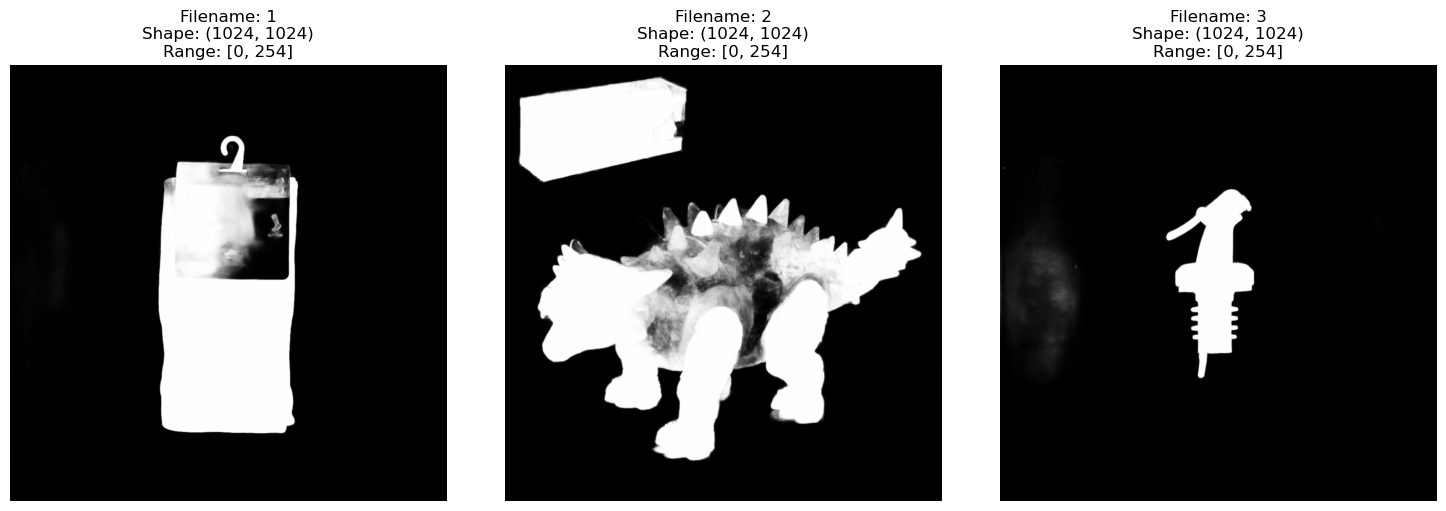


Успешно декодировано и визуализировано 3 изображений из submission.csv


In [ ]:
# Визуализация submission.csv - декодирование и отображение предсказанных масок
import base64
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Путь к submission файлу
submission_path = Path("outputs/experiments/exp_001/submission_8.csv")
#submission_path = Path("data/example_submission.csv")

if not submission_path.exists():
    print(f"Файл не найден: {submission_path}")
else:
    df = pd.read_csv(submission_path)
    print(f"Загружено строк: {len(df)}")
    print(f"Колонки: {df.columns.tolist()}")
    print(f"Первые 3 filename: {df.head(3)['filename'].tolist()}")

    def decode_png(b64):
        """Декодирует base64 строку в PIL Image"""
        data = base64.b64decode(b64)
        im = Image.open(io.BytesIO(data))
        im.load()
        return im

    # Визуализация первых N изображений
    n_show = min(3, len(df))
    fig, axes = plt.subplots(1, n_show, figsize=(5 * n_show, 5))
    
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        fn = df.loc[i, "filename"]
        b64 = df.loc[i, "image_utf"]
        
        try:
            im = decode_png(b64)
            arr = np.array(im)
            
            axes[i].imshow(arr, cmap="gray", vmin=0, vmax=255)
            axes[i].set_title(f"Filename: {fn}\nShape: {arr.shape}\nRange: [{arr.min()}, {arr.max()}]")
            axes[i].axis("off")
            
            print(f"\n[{i+1}] {fn}: shape={arr.shape}, dtype={arr.dtype}, min={arr.min()}, max={arr.max()}")
        except Exception as e:
            print(f"Ошибка при декодировании {fn}: {e}")
            axes[i].text(0.5, 0.5, f"Error:\n{str(e)}", ha="center", va="center")
            axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nУспешно декодировано и визуализировано {n_show} изображений из submission.csv")

